In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from collections import defaultdict
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
import keras.backend as K
import string

In [2]:
# Reading the data
dataset = pd.read_json('../data/renttherunway_final_data.json.gz', lines=True)
dataset = dataset.dropna()
dataset = dataset.drop(dataset[dataset['rented for']== "party: cocktail"].index)

# 0 = Small, 1 = Fit, 2 = Large
dataset.loc[dataset["fit"] == "small", "fit"] = 0

dataset.loc[dataset["fit"] == "fit", "fit"] = 1

dataset.loc[dataset["fit"] == "large", "fit"] = 2

In [3]:
# Converting the data into list of dictionaries
data = pd.DataFrame(dataset).to_dict('record')

for d in data:
    d['weight'] = int(d['weight'].split('lbs')[0])
    d['height'] = int(d['height'].split(' ')[0][:-1])*12 + int(d['height'].split(' ')[1][:-1])

catogeries = ['rented for','body type']
for cat in catogeries:
    categories_list = defaultdict(int)
    for d in data:
        categories_list[d[cat]] += 1
        
    categories_id = defaultdict(int)

    i = 0
    for cID in  categories_list:
        categories_id[cID] = i
        i+=1
    for d in data:
        f = [0]*len(categories_list)
        f[categories_id[d[cat]]] = 1
        d[cat] = f[:len(categories_list)-1]

/var/folders/bl/rv0p_vz52hzcccft68rtk3840000gn/T/ipykernel_16813/1164200574.py:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  data = pd.DataFrame(dataset).to_dict('record')


In [4]:
embeddings_dict = {}
with open("glove.6B.50d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [5]:
# import io

# def load_vectors(fname):
#     fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
#     n, d = map(int, fin.readline().split())
#     data = {}
#     for line in fin:
#         tokens = line.rstrip().split(' ')
#         data[tokens[0]] = map(float, tokens[1:])
#     return data

# embeddings_dict = load_vectors("wiki-news-300d-1M.vec")

In [6]:
def get_word_embeddings(word):
    try:
        return embeddings_dict[word]
    except KeyError:
        return np.zeros(50)

In [7]:
punctuation = set(string.punctuation)
type(embeddings_dict['the'])

numpy.ndarray

In [8]:
# Add features
df = []
for d in data:
    arr = []
#     arr.append(d['weight'])
    arr.append(d['rating'])
    arr += d['rented for']
    arr += list(sum([get_word_embeddings(word) for word in d['review_text'].split()])/len([get_word_embeddings(word) for word in d['review_text'].split()]))
    try:
        arr += list(sum([get_word_embeddings(word) for word in d['review_summary'].split()])/(len([get_word_embeddings(word) for word in d['review_summary'].split()])+1))
    except:
        arr += [0]*50
    
#     arr.append(len(d['review_text']))
    arr += d['body type']
#     arr.append(d['height'])
    arr.append(d['size'])
#     arr.append(d['age'])
    df.append(arr)

In [9]:
y = dataset["fit"]
y_cat = to_categorical(y)
split_ratio = .85
# Split data
test_y = y_cat[int(len(y_cat) * split_ratio):]
train_y = y_cat[:int(len(y_cat) * split_ratio)]
test_f = df[int(len(y_cat) * split_ratio):]
train_f = df[:int(len(y_cat) * split_ratio)]

# Convert to numpy array.
test_f = np.array(test_f)
train_f = np.array(train_f)

In [10]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
model = Sequential()
model.add(Dense(60, input_shape = (len(train_f[0]), ), activation = "relu"))
model.add(Dense(40, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(3, activation = "softmax"))
model.compile(Adam(lr = 0.001), "categorical_crossentropy", metrics = ['acc',f1_m,precision_m, recall_m])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 60)                6960      
_________________________________________________________________
dense_1 (Dense)              (None, 40)                2440      
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 123       
Total params: 9,523
Trainable params: 9,523
Non-trainable params: 0
_________________________________________________________________


2021-11-30 16:11:59.029247: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [12]:
model.fit(train_f, train_y, verbose=1, epochs=20)

2021-11-30 16:11:59.333041: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
3889/3889 [==============================] - 4s 814us/step - loss: 0.7034 - acc: 0.7380 - f1_m: 0.7326 - precision_m: 0.7614 - recall_m: 0.7072
Epoch 2/20
3889/3889 [==============================] - 3s 839us/step - loss: 0.6841 - acc: 0.7430 - f1_m: 0.7358 - precision_m: 0.7676 - recall_m: 0.7077
Epoch 3/20
3889/3889 [==============================] - 4s 975us/step - loss: 0.6782 - acc: 0.7447 - f1_m: 0.7386 - precision_m: 0.7680 - recall_m: 0.7124
Epoch 4/20
3889/3889 [==============================] - 4s 1ms/step - loss: 0.6744 - acc: 0.7457 - f1_m: 0.7398 - precision_m: 0.7681 - recall_m: 0.7147
Epoch 5/20
3889/3889 [==============================] - 4s 1ms/step - loss: 0.6712 - acc: 0.7468 - f1_m: 0.7415 - precision_m: 0.7685 - recall_m: 0.7173
Epoch 6/20
3889/3889 [==============================] - 4s 971us/step - loss: 0.6678 - acc: 0.7484 - f1_m: 0.7426 - precision_m: 0.7698 - recall_m: 0.7181
Epoch 7/20
3889/3889 [==============================] - 4s 1ms/step - loss

In [13]:
# Confusion matrix
# y_pred_class = model.predict_classes(test_f)
predict_x=model.predict(test_f) 
y_pred_class=np.argmax(predict_x,axis=1)

In [14]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(test_f)
y_test_class = np.argmax(test_y, axis=1)
confusion_matrix(y_test_class, y_pred_class)

array([[  353,  2543,    78],
       [  184, 15874,   103],
       [  114,  2441,   267]])

In [15]:
y_pred

array([[0.07941305, 0.8659572 , 0.05462974],
       [0.22949485, 0.6122828 , 0.15822235],
       [0.03201224, 0.8580395 , 0.10994828],
       ...,
       [0.257764  , 0.51414365, 0.22809228],
       [0.08388903, 0.87520146, 0.04090962],
       [0.19315907, 0.77320945, 0.03363152]], dtype=float32)

In [16]:
y_pred_class

array([1, 1, 1, ..., 1, 1, 1])

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_class, y_pred_class).round(4)

0.7512

In [18]:
from sklearn.metrics import f1_score
f1_score(y_test_class, y_pred_class, average='weighted').round(4)

0.6786

In [19]:
from sklearn.metrics import recall_score
recall_score(y_test_class, y_pred_class, average='weighted').round(4)

0.7512

In [20]:
from sklearn.metrics import precision_score
precision_score(y_test_class, y_pred_class, average='weighted').round(4)

0.7102

baseline: ROC AUC=0.500
deep learning: ROC AUC=0.733


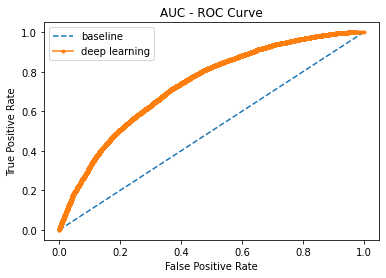

In [21]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

ns_probs = np.array([[0,1,0] for _ in range(len(test_y))])

lr_probs = y_pred
# keep probabilities for the positive outcome only

# calculate scores

lr_auc = roc_auc_score(y_test_class, lr_probs, multi_class='ovr')
ns_auc = roc_auc_score(y_test_class, ns_probs, multi_class='ovr')

ns_probs = ns_probs[:, 1]
lr_probs = lr_probs[:, 1]

for y in range(len(y_test_class)):
    if y_test_class[y] == 2:
        y_test_class[y] = 0
        
print('baseline: ROC AUC=%.3f' % (ns_auc))
print('deep learning: ROC AUC=%.3f' % (lr_auc))
        
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test_class, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test_class, lr_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='baseline')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='deep learning')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title("AUC - ROC Curve")

# show the legend
pyplot.legend()
pyplot.savefig("./roc curve and auc.png")

# show the plot
pyplot.show()

Deep Learning: f1=0.669 auc=0.868


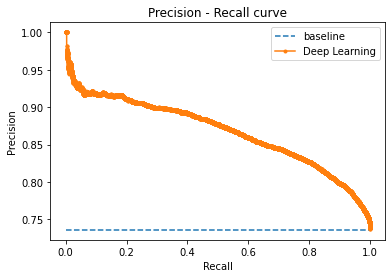

In [25]:
# precision-recall curve and f1
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

# predict probabilities
lr_probs = y_pred
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = y_pred_class

lr_precision, lr_recall, _ = precision_recall_curve(y_test_class, lr_probs)
lr_f1, lr_auc = f1_score(y_test_class, yhat, average='weighted'), auc(lr_recall, lr_precision)

# summarize scores
print('Deep Learning: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len([x for x in y_test_class if x==1]) / len(y_test_class)

pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='baseline')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Deep Learning')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.title("Precision - Recall curve")
# show the legend
pyplot.legend()
pyplot.savefig("./precision-recall.png")
# show the plot
pyplot.show()

In [23]:
lr_recall

array([1.00000000e+00, 9.99938123e-01, 9.99938123e-01, ...,
       1.23754718e-04, 6.18773591e-05, 0.00000000e+00])

In [24]:
lr_precision

array([0.73791151, 0.73789954, 0.73793324, ..., 1.        , 1.        ,
       1.        ])